<a href="https://colab.research.google.com/github/Thirdsense3/VisualComputins_test/blob/master/%5B%EA%B8%B0%EB%A7%90_%EA%B3%BC%EC%A0%9C_1%5D_Fashion_MNIST_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K 

tf.keras.backend.clear_session()

# Check version
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.2.0


Using TensorFlow backend.


In [2]:
# Load : Fashion MNIST Dataest
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train  = len(x_train)
size_of_test  = len(x_test)
num_of_class = 10

print('The Shape of dataset:', x_train[0].shape)
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

4423680/4422102 [==============================] - 0s 0us/step
The Shape of dataset: (28, 28)
The number of train image: 60000
The number of test image: 10000


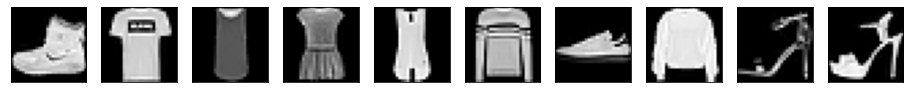

In [3]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(x_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [4]:
print('== Before normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

## Dataset Pre-processing ##
# Normalization
x_train = x_train/255.  
x_test = x_test/255. 

# Reshape(Adding channel)
x_train = x_train.reshape((size_of_train, 28, 28, 1))
x_test = x_test.reshape((size_of_test, 28, 28, 1))

print('\n== After normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

== Before normalization ==
Image Shape: (28, 28)
Value MIN: 0, MEAN:97.25, MAX:255

== After normalization ==
Image Shape: (28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1


In [5]:
def channel_attention(x, name):
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
    x2 = tf.keras.layers.Dense(x.shape[3]/2, activation = 'relu')(x1)
    x3 = tf.keras.layers.Dense(x.shape[3], activation = 'sigmoid')(x2)

    x_result = tf.keras.layers.Multiply()([x,x3])

    return  x_result

def spatial_attention(x, name):
    x1 = tf.keras.layers.Conv2D(x.shape[3],padding='same', kernel_size=(3, 3), activation = 'sigmoid')(x)
    x_result = tf.keras.layers.Multiply()([x,x1])
    
    return  x
 
def autoencoder_block(x, filter, name): 
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, strides=(1, 1), padding='same', name=name+'_conv')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    return x

In [6]:
def autoencoder(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_channel_Serial(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = channel_attention(x,'channel_attention1')
    x = spatial_attention(x,'spatial_attention1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)


    x = autoencoder_block(x, 32, 'encoder2')
    x = channel_attention(x,'channel_attention2')
    x = spatial_attention(x,'spatial_attention2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)

    encoded_img = autoencoder_block(x, 64, 'encoder3')
    encoded_img = channel_attention(x,'channel_attention3')
    encoded_img = spatial_attention(x,'spatial_attention3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = channel_attention(x,'channel_attention1')
    x = spatial_attention(x,'spatial_attention1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)

    x = autoencoder_block(x, 32, 'decoder2')
    x = channel_attention(x,'channel_attention2')
    x = spatial_attention(x,'spatial_attention2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)

    x = autoencoder_block(x, 16, 'decoder3')
    x = channel_attention(x,'channel_attention3')
    x = spatial_attention(x,'spatial_attention3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_channel_Parallel(input):
  # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x1 = channel_attention(x,'channel_attention1')
    x2 = spatial_attention(x,'spatial_attention1')
    x = tf.keras.layers.Add()([x1,x2])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)


    x = autoencoder_block(x, 32, 'encoder2')
    x1 = channel_attention(x,'channel_attention2')
    x2 = spatial_attention(x,'spatial_attention2')
    x = tf.keras.layers.Add()([x1,x2])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)

    encoded_img = autoencoder_block(x, 64, 'encoder3')
    encoded_img1 = channel_attention(x,'channel_attention3')
    encoded_img2 = spatial_attention(x,'spatial_attention3')
    encoded_img = tf.keras.layers.Add()([encoded_img1,encoded_img2])

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x1 = channel_attention(x,'channel_attention1')
    x2 = spatial_attention(x,'spatial_attention1')
    x = tf.keras.layers.Add()([x1,x2])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)

    x = autoencoder_block(x, 32, 'decoder2')
    x1 = channel_attention(x,'channel_attention2')
    x2 = spatial_attention(x,'spatial_attention2')
    x = tf.keras.layers.Add()([x1,x2])
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)

    x = autoencoder_block(x, 16, 'decoder3')
    x1 = channel_attention(x,'channel_attention3')
    x2 = spatial_attention(x,'spatial_attention3')
    x = tf.keras.layers.Add()([x1,x2])

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img


# Normal AutoEncoder Model Create / Summary
input_data = tf.keras.Input(shape=(28, 28, 1))

output_data = autoencoder(input_data)
output_channel_Serial_data = autoencoder_channel_Serial(input_data)
output_channel_Parallel_data = autoencoder_channel_Parallel(input_data)

model = tf.keras.Model(inputs=input_data, outputs=output_data)
model_channel_Serial  = tf.keras.Model(inputs=input_data, outputs=output_channel_Serial_data)
model_channel_Parallel  = tf.keras.Model(inputs=input_data, outputs=output_channel_Parallel_data)

model.summary()
model_channel_Serial.summary()
model_channel_Parallel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder1_conv (Conv2D)       (None, 28, 28, 16)        160       
_________________________________________________________________
encoder1_bn (BatchNormalizat (None, 28, 28, 16)        64        
_________________________________________________________________
encoder1_relu (ReLU)         (None, 28, 28, 16)        0         
_________________________________________________________________
encoder_pool1 (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
encoder2_conv (Conv2D)       (None, 14, 14, 32)        4640      
_________________________________________________________________
encoder2_bn (BatchNormalizat (None, 14, 14, 32)        128   

In [7]:
# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model_channel_Serial.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_channel_Parallel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [8]:
# Training
print('Training Model')

# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history = model.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=2,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_channel_Serial = model_channel_Serial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=2,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_channel_Parallel = model_channel_Parallel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=2,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model
Epoch 1/2
3750/3750 [==============================] - 32s 9ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 2/2
3750/3750 [==============================] - 34s 9ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 1/2
3750/3750 [==============================] - 43s 11ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/2
3750/3750 [==============================] - 42s 11ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 1/2
3750/3750 [==============================] - 45s 12ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 2/2
3750/3750 [==============================] - 45s 12ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0030 - val_mse: 0.0030


In [9]:
# Model Predict
recons = model.predict(x_test)
recons_channel_Serial = model_channel_Serial.predict(x_test)
recons_channel_Parallel = model_channel_Parallel.predict(x_test)

In [10]:
recons = recons.reshape(-1, 28, 28)
recons_channel_Serial = recons_channel_Serial.reshape(-1,28,28)
recons_channel_Parallel = recons_channel_Parallel.reshape(-1,28,28)


test_imgs = (x_test * 255).reshape(-1, 28, 28)

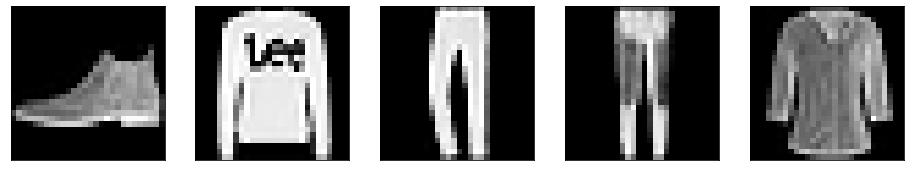

In [11]:
# Test Data Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(test_imgs[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

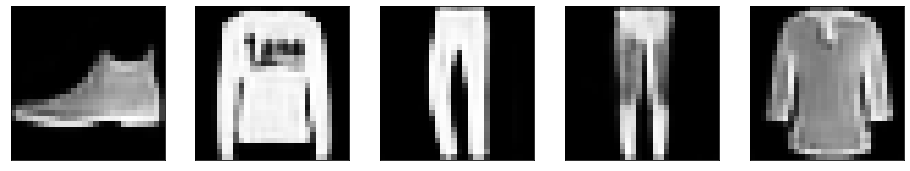

In [12]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

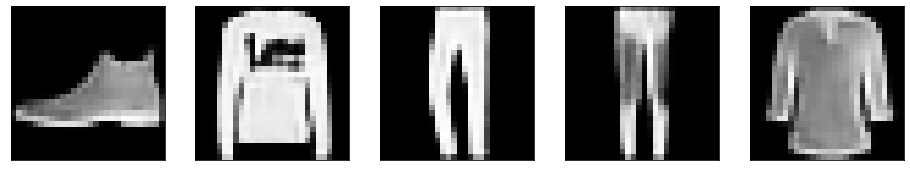

In [13]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel_Serial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

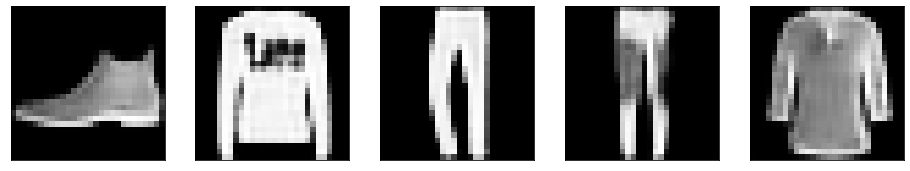

In [14]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel_Parallel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

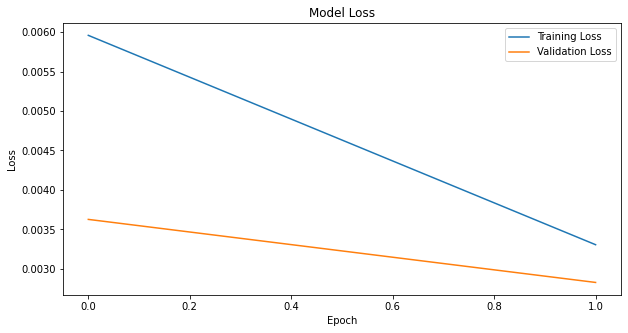

In [15]:
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

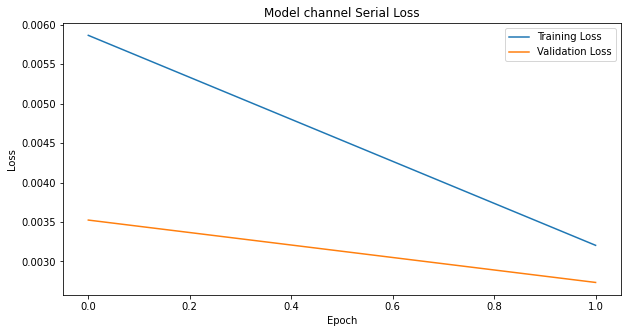

In [16]:
plt.figure(figsize=(10, 5))

plt.plot(history_channel_Serial.history['loss'])
plt.plot(history_channel_Serial.history['val_loss'])
plt.title('Model channel Serial Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

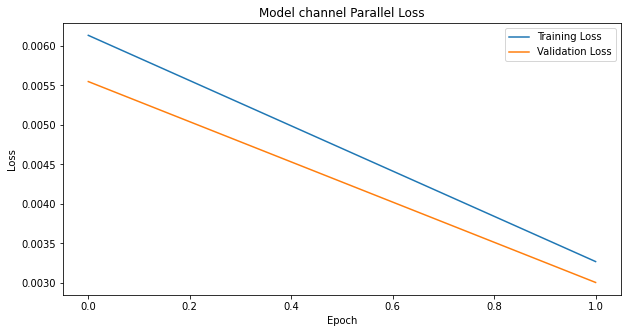

In [17]:
plt.figure(figsize=(10, 5))

plt.plot(history_channel_Parallel.history['loss'])
plt.plot(history_channel_Parallel.history['val_loss'])
plt.title('Model channel Parallel Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()